In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *


# define GPU id to use
# 0 = 1080 Bus ID 2
# 1 = Titan Bus ID 131
# 2 = Titan Bus ID 132
GPU_IDS = '0,1'
current_gpu = choose_gpu_by_id(GPU_IDS)
print(current_gpu)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# import helpers
from src.utils.utils_io import Console_and_file_logger, init_config
from src.visualization.visualize import show_2D_or_3D
from src.data.dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df
from src.data.generators import DataGenerator, get_samples
from src.utils.unet_3d_metrics import weighted_dice_coefficient_loss
from src.models.ModelManager import get_model
from src.utils.KerasCallbacks import get_callbacks
import src.utils.my_metrics as metr


# define experiment name for report, model and log paths + filenames
EXPERIMENT = 'motion/2D/gcn'
now = datetime.datetime.now()

# image params, change for different input data/architecture
ARCHITECTURE = '2D' # 2D
DIM = [224, 224]

SPACING = [1.0,1.0] # used by sitk, opposite order than numpy or tensorflow!
IMG_CHANNELS = 1
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
# Background = 0 = Y[:,:,0]
# RV = 1 = Y[:,:,1] 
# Myo = 2 = Y[:,:,2] 
# LV = 3 = Y[:,:,3]
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = False

# path params
DATASET = 'gcn'

MODEL_PATH = os.path.join(os.path.join('models', EXPERIMENT), str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join(os.path.join('reports/tensorboard_logs', EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join(os.path.join('reports/configs/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join(os.path.join('reports/history/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))

# training params
GENERATOR_WORKER = 4 # if not set, use batchsize
seed = 42
BATCHSIZE =  2 # 32, 64, 24, 16, 1
INITIAL_EPOCH = 0
EPOCHS = 150
FOLDS = 4
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'

# Network params
OPTIMIZER = 'Adam'  # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu'  # 'elu' --> works well with binary_crossentropy and bce_dice_loss, relu does not work, it clips negative values, bse does return negative values
LEARNING_RATE = 0.001
DECAY = 0.0
EPSILON = 1e-08
DROPOUT_L1_L2 = 0.4 # higher dropout at the deeper layers
DROPOUT_L3_L4 = 0.4
DROPOUT_L5 = 0.5
BATCH_NORMALISATION = True
USE_UPSAMPLE = True # otherwise use transpose

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv,
]

LOSS_FUNCTION = metr.bce_dice_jac_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)


# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(locals(), True)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2019-10-10 08:50:07,824 INFO -------------------- Start --------------------
2019-10-10 08:50:07,825 INFO Working directory: /mnt/data/git/cardio.
2019-10-10 08:50:07,825 INFO Log file: ./logs/motion/2D/gcn.log


['gpu(0)', 'gpu(1)']


# Load 2D slices from patients with 5 labelled timesteps (193 of 202 patients)

In [2]:
df = pd.read_csv('reports/motion/2D/gcn/only_2d_slices_with_5_timesteps.csv')

In [3]:
from src.data.generators import MotionDataGenerator
# create a list of z slices with t_n and t_n+1 , not possible for the last timestep
t_1 = np.concatenate([df[df['t_norm'] == 0]['x_path'].values, df[df['t_norm'] == 1]['x_path'].values, df[df['t_norm'] == 2]['x_path'].values, df[df['t_norm'] == 3]['x_path'].values])
t_2 = np.concatenate([df[df['t_norm'] == 1]['x_path'].values, df[df['t_norm'] == 2]['x_path'].values, df[df['t_norm'] == 3]['x_path'].values, df[df['t_norm'] == 4]['x_path'].values])
batch_generator = MotionDataGenerator(t_1, t_2, config)

2019-10-10 08:50:08,537 INFO Create DataGenerator
2019-10-10 08:50:08,570 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 2
 Scaler: MinMax
 Images: 10764 
 Augment_grid: False 
 Thread workers: 4
2019-10-10 08:50:08,570 INFO No augmentation


In [4]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(batch_generator), 1)):
    global x, y
    input_ , output_ = batch_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    logging.info(x.shape)
    logging.info(y.shape)

interactive(children=(IntSlider(value=2691, description='batch', max=5382), Output()), _dom_classes=('widget-i…

In [5]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    show_2D_or_3D(x[im])
    plt.show()
    show_2D_or_3D(y[im])
    plt.show()

interactive(children=(IntSlider(value=0, description='im', max=1), Output()), _dom_classes=('widget-interact',…

In [6]:
sys.path.append('src/models/ext/neuron')
sys.path.append('src/models/ext/pynd-lib')
sys.path.append('src/models/ext/pytools-lib')

In [7]:
from src.models.src.networks import cvpr2018_net
from keras.losses import mean_squared_error as mse
from keras.utils import multi_gpu_model
from src.models.src.losses import Grad
gpu_ids = config.get('GPU_IDS', '1').split(',')

model = cvpr2018_net([224,224], enc_nf=[16,32,32,32], dec_nf=[32,32,32,32,16,3])
model = multi_gpu_model(model, gpus=len(gpu_ids), cpu_merge=False) if (len(gpu_ids) > 1) else model
model.compile(optimizer=keras.optimizers.Adam(), loss=['mse', Grad('l2').loss],
                         loss_weights=[1.0, 0.01]) # values used by the CVPR paper

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_3 (

In [9]:
plot_model(model, to_file=os.path.join(config.get('CONFIG_PATH'),'model.png'), show_shapes=True)

In [10]:
initial_epoch = 0
# training

# start a new main process for this training to free gpu memory afterwards
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit_generator(
    generator=batch_generator,
    epochs=100,
    callbacks = get_callbacks(config),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    max_queue_size=30,
    workers=8,
    #use_multiprocessing=True,
    verbose=1)

2019-10-10 08:50:23,952 INFO Fit model, start trainings process


Epoch 1/100
5382/5382 [==============================] - 39s 7ms/step - loss: 0.0019 - spatial_transformer_1_loss: 0.0018 - flow_loss: 0.0119


2019-10-10 08:51:07,550 INFO Saved model to disk: models/motion/2D/gcn/2019-10-10_08_50



Epoch 00001: loss improved from inf to 0.00188, saving model to models/motion/2D/gcn/2019-10-10_08_50/checkpoint.h5
Epoch 2/100
5382/5382 [==============================] - 36s 7ms/step - loss: 0.0015 - spatial_transformer_1_loss: 0.0013 - flow_loss: 0.0169

Epoch 00002: loss improved from 0.00188 to 0.00151, saving model to models/motion/2D/gcn/2019-10-10_08_50/checkpoint.h5
Epoch 3/100
5382/5382 [==============================] - 36s 7ms/step - loss: 0.0014 - spatial_transformer_1_loss: 0.0013 - flow_loss: 0.0183

Epoch 00003: loss improved from 0.00151 to 0.00144, saving model to models/motion/2D/gcn/2019-10-10_08_50/checkpoint.h5
Epoch 4/100
5382/5382 [==============================] - 36s 7ms/step - loss: 0.0014 - spatial_transformer_1_loss: 0.0012 - flow_loss: 0.0190

Epoch 00004: loss improved from 0.00144 to 0.00140, saving model to models/motion/2D/gcn/2019-10-10_08_50/checkpoint.h5
Epoch 5/100
5382/5382 [==============================] - 37s 7ms/step - loss: 0.0014 - spatial

KeyboardInterrupt: 

In [113]:
# use the batch generator for training
test_config = config.copy()
test_config['SHUFFLE'] = False
test_config['BATCHSIZE'] = 64
test_config['AUGMENT_GRID'] = False
test_generator = MotionDataGenerator(t_1, t_2, test_config)


2019-10-10 11:13:43,982 INFO Create DataGenerator
2019-10-10 11:13:44,014 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 64
 Scaler: MinMax
 Images: 10764 
 Augment_grid: False 
 Thread workers: 4
2019-10-10 11:13:44,014 INFO No augmentation


In [115]:
# Select batch generator output
x = ''
y = ''
input_ = ''
@interact
def select_batch(batch = (0,len(test_generator), 1)):
    global x, y, input_
    input_ , output_ = test_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    logging.info(x.shape)
    logging.info(y.shape)

interactive(children=(IntSlider(value=84, description='batch', max=168), Output()), _dom_classes=('widget-inte…

In [116]:
pred = model.predict(input_)

warped, flowfield = pred
warped.shape
flowfield.shape
flowfield[0].mean()

In [123]:
flowfield.shape
df.head()

(64, 224, 224, 2)

,Unnamed: 0,Unnamed: 0.1,fold,x_path,y_path,modality,patient,t,z,t_norm
0,240,43789,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,0,1
1,241,43790,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,10,1
2,242,43791,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,11,1
3,243,43792,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,12,1
4,244,43793,0,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,data/raw/tetra/2D/train/0003-04NEJQUZ-2007-03-...,train,0003-04NEJQUZ-2007-03-13,12,13,1


In [92]:
np.save('reports/numpy_files/input64.npy', input_)
np.save('reports/numpy_files/warped64.npy', warped)
np.save('reports/numpy_files/flowfield64.npy', flowfield)

In [2]:
warped = np.load('reports/numpy_files/warped.npy')
flowfield = np.load('reports/numpy_files/flowfield.npy')

In [120]:
@interact
def show_flowfield(img = (0,x.shape[0]- 1)):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(30,4))

    
    ax1.set_title('X-flow')
    ax1.imshow(flowfield[img,:,:,0]);
    ax2.set_title('Y-flow')
    ax2.imshow(flowfield[img,:,:,1]);
    ax3.set_title('image_t0')
    ax3.imshow(x[img,:,:,0])
    ax4.set_title('image_warped')
    ax4.imshow(warped[img,:,:,0]) # x warped, should bee similar to y
    ax5.set_title('image_tn')
    ax5.imshow(y[img,:,:,0]) # target
    diff_ = y[img,:,:,0]- warped[img,:,:,0]
    ax6.set_title('gt - image warped \ndiff: {:4f} '.format(abs(diff_.sum())))
    ax6.imshow(diff_) # difference
    ax7.set_title('quiver flowfield')
    
    flow_X = flowfield[img,:,:,0]
    flow_Y = flowfield[img,:,:,1]

    N = 5
    Fx = flow_X[::N, ::N]
    Fy = flow_Y[::N, ::N]

    nrows, ncols = Fx.shape
    nx = 2
    ny = 2
    x_ = np.linspace(-nx, nx, ncols)
    y_ = np.linspace(-ny, ny, nrows)
    xi, yi = np.meshgrid(x_, y_, indexing='ij')

    #plt.axes([0.065, 0.065, 0.9, 0.9])#
    ax7.quiver(yi, -xi , Fx, Fy, alpha=.5)
    ax7.quiver(yi, -xi, Fx, Fy, edgecolor='k', facecolor='none', linewidth=.5)

    plt.show()


interactive(children=(IntSlider(value=31, description='img', max=63), Output()), _dom_classes=('widget-interac…

In [112]:
@interact
def plot_quiver_from_motion(img=(0,flowfield.shape[0]-1)):
    
    fix, ax = plt.subplots(figsize=(12,12))
    
    Y = flowfield[img,:,:,0]
    X = flowfield[img,:,:,1]

    N = 4
    Fx = X[::N, ::N]
    Fy = Y[::N, ::N]

    nrows, ncols = Fx.shape
    nx = 2
    ny = 2
    x = np.linspace(-nx, nx, ncols)
    print(Fx.shape)
    print(Fy.shape)
    y = np.linspace(-ny, ny, nrows)
    xi, yi = np.meshgrid(x, y, indexing='ij')

    #plt.axes([0.065, 0.065, 0.9, 0.9])#
    plt.quiver(yi, -xi , Fx, Fy, alpha=.5)
    plt.quiver(yi, -xi, Fx, Fy, edgecolor='k', facecolor='none', linewidth=.5)

    plt.show()


interactive(children=(IntSlider(value=31, description='img', max=63), Output()), _dom_classes=('widget-interac…

In [16]:
X.shape

(224, 224)

(-5, 5)

(-5, 5)

Text(0.5, 1.0, 'How to plot a vector in matplotlib ?')

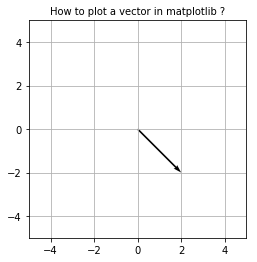

In [17]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array((0))
Y= np.array((0))
U = np.array((2))
V = np.array((-2))

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V,units='xy' ,scale=1)

plt.grid()

ax.set_aspect('equal')

plt.xlim(-5,5)
plt.ylim(-5,5)

plt.title('How to plot a vector in matplotlib ?',fontsize=10)
plt.show()


(0, 50)

(0, 100)

Text(0.5, 1.0, 'How to plot a vector field using matplotlib ?')

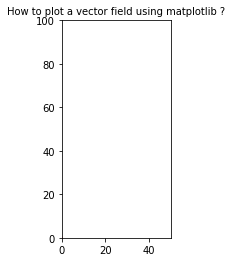

In [19]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(X[np.newaxis], Y[np.newaxis])

x_shape = X.shape

U = np.zeros(x_shape)
V = np.zeros(x_shape)

for i in range(x_shape[0]):
    for j in range(x_shape[1]):
        U[i,j] = 1.0
        V[i,j] = 1.0

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='red')

ax.set_aspect('equal')

plt.xlim(0,50)
plt.ylim(0,100)

plt.title('How to plot a vector field using matplotlib ?',fontsize=10)
plt.show()

In [20]:
x_shape

(1, 1)